# Visual Inspection of Motorcycle Connecting Rods
Author: Matteo Periani<br>
student-id: 0001039848<br>
date: 11/2022


In [647]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

## Import image
Import first image

In [648]:
img_path = "./images/task2/task22/TESI51.BMP"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

Binirize image with Otsu' method

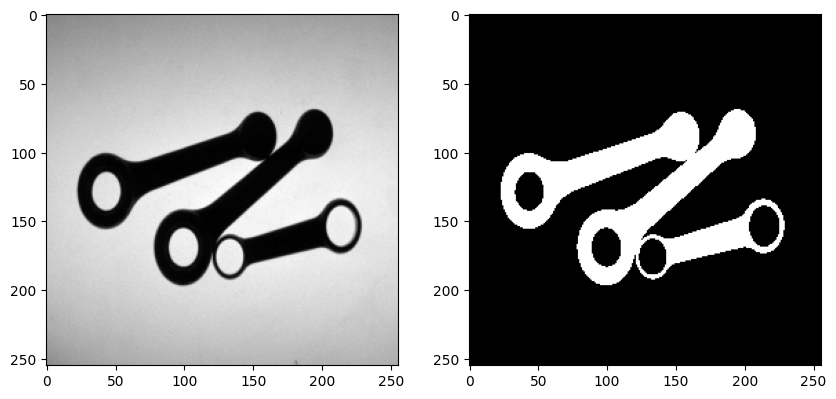

In [649]:
_, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

f, plts = plt.subplots(1, 2, figsize=(10,10)) 
plts[0].imshow(img, cmap="gray")
plts[1].imshow(binarized_img, cmap="gray")
plt.show()

## Remove dust and dirt noise
start with a median blur to remove the most dust and dirt

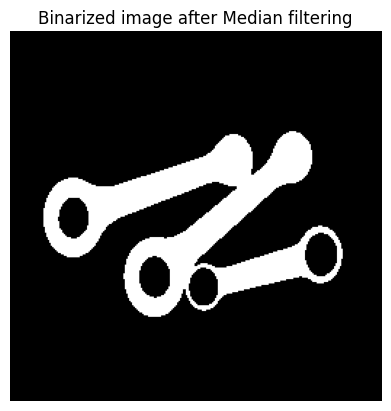

In [650]:
img_bin_blur = cv2.medianBlur(binarized_img, 3)

plt.imshow(img_bin_blur, cmap='gray')
plt.title('Binarized image after Median filtering')
plt.axis('off')
plt.show()

Affine noise elimination (Dilation -> Opening -> 2x Dilation -> 2x Erosion)

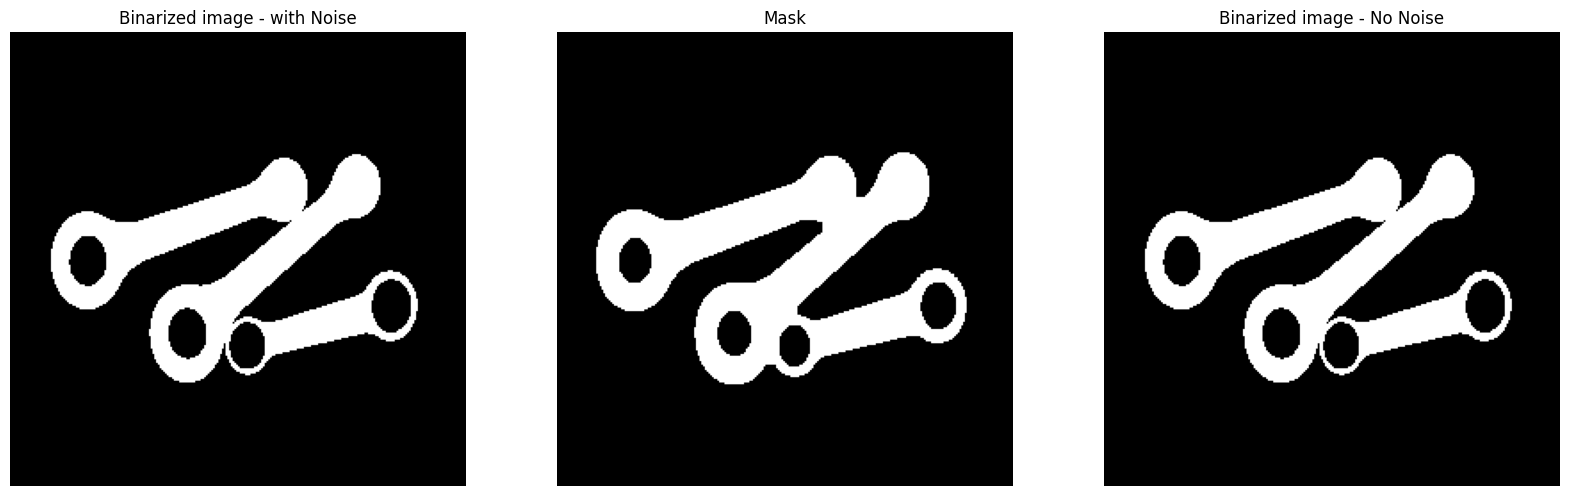

In [651]:
# Kernels for Morphological Operators
cross5 = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
cross3 = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
square5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
square3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

# Dilation (to keep thin borders safe from Opening) -> Opening -> 2x Dilation -> 2x Erosion
dilation1 = cv2.dilate(img_bin_blur, square3, iterations = 1)
opening = cv2.morphologyEx(dilation1, cv2.MORPH_OPEN, cross5)
dilation2 = cv2.dilate(opening, square3, iterations = 2)
erosion = cv2.erode(dilation2, square3, iterations = 2)

# Other 2 steps of median filtering to remove residual noise
mask = cv2.medianBlur(cv2.medianBlur(cv2.bitwise_and(binarized_img, erosion), 3), 3)

# The final binarized image is obtained from the original image and the related mask
img_bin_denoised = cv2.bitwise_and(mask, binarized_img)

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(binarized_img, cmap='gray')
plt.title('Binarized image - with Noise')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(erosion, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_bin_denoised, cmap='gray')
plt.title('Binarized image - No Noise')
plt.axis('off')
plt.show()


## Separate touching rods
As first things, remove rods holes to prevent internal ersosion.

(-0.5, 255.5, 254.5, -0.5)

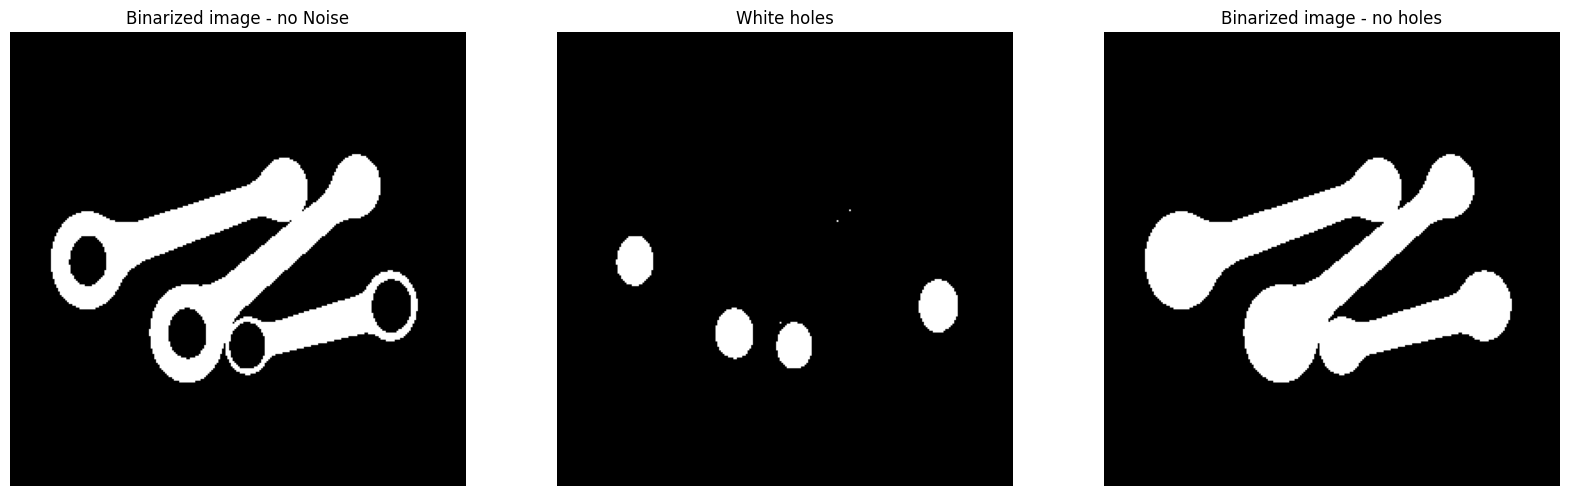

In [652]:
white_holes = img_bin_denoised.copy()
# Flood-filling
h, w = img_bin_denoised.shape[:2]
mask_filling = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(white_holes, mask_filling, (0,0), 255);
white_holes = cv2.bitwise_not(white_holes)
img_no_holes = img_bin_denoised + white_holes

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(img_bin_denoised, cmap='gray')
plt.title('Binarized image - no Noise')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(white_holes, cmap='gray')
plt.title('White holes')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_no_holes, cmap='gray')
plt.title('Binarized image - no holes')
plt.axis('off')

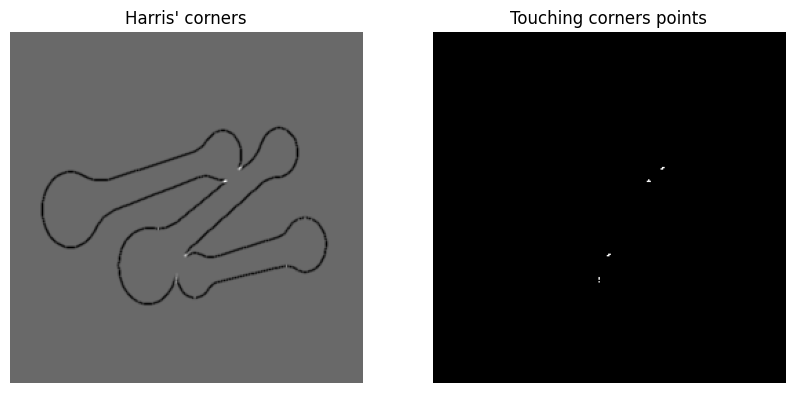

In [653]:
# Find Corners
corner_pts = cv2.cornerHarris(img_no_holes,2,5,0.04)

# Find Centroids of touching corners
_, _, _, centroids = cv2.connectedComponentsWithStats(((corner_pts>1)*255).astype('uint8'), 8)

# Show corners in the image
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(corner_pts, cmap='gray')
plt.title("Harris' corners")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(((corner_pts>1)*255).astype('uint8'), cmap='gray')
plt.title("Touching corners points")
plt.axis('off')
plt.show()

In order to discard centroids that are very close to each other, we filter them by tresholing based on distance

In [654]:
# start form index 1 to not take into account the all image barycenter
centroids = [tuple(c) for c in centroids[1:]]
good_centroids = centroids

print(f"All centroids: {centroids}")

i = 1    
for c1 in centroids:
    for c2 in centroids[i::1]:
        if(dist.euclidean(c1, c2) < 10):
            good_centroids.remove(c2)
    i+=1
    
print(f"Good centroids: {good_centroids}")

All centroids: [(166.0, 98.5), (156.0, 107.75), (127.0, 161.5), (120.0, 178.5), (120.0, 181.0)]
Good centroids: [(166.0, 98.5), (156.0, 107.75), (127.0, 161.5), (120.0, 178.5)]


Now, to separate rods we have to find the pairs of points that are used in the next step to draw the line. To do this, we need to find the closet touple of points cordinates and store them together. Beacuse of that, we need at lest two centorids to perform this operation.

In [655]:
lines_extremes = []
n_centroids = len(good_centroids)

# If there are at least two good centroids
if n_centroids >= 2:
    # Find all the Conjunctions between pairs of near Centroids
    for i in range(n_centroids):
        min_pair_dist = np.Inf
        for j in range(n_centroids):
            if i != j:
                d = dist.euclidean(good_centroids[i], good_centroids[j])
                if d < min_pair_dist and d > 10: 
                    min_pair_dist = d
                    best_i = i
                    best_j = j
        if (good_centroids[best_i], good_centroids[best_j]) not in lines_extremes:
            lines_extremes.append((good_centroids[best_i], good_centroids[best_j]))
    
print(lines_extremes)

[((166.0, 98.5), (156.0, 107.75)), ((156.0, 107.75), (166.0, 98.5)), ((127.0, 161.5), (120.0, 178.5)), ((120.0, 178.5), (127.0, 161.5))]


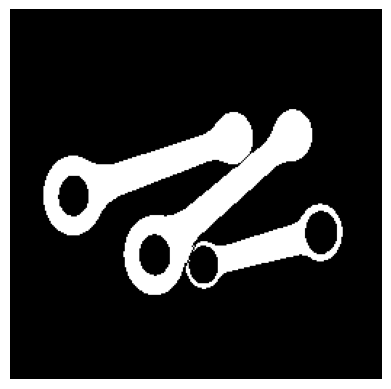

In [656]:
lines_extremes = [(round(pt[0]), round(pt[1])) for e in lines_extremes for pt in e]

im_bin_sep = np.copy(img_bin_denoised)

# Draw separation lines
for i in range(0, len(lines_extremes), 2):
    im_bin_sep = cv2.line(im_bin_sep, lines_extremes[i], lines_extremes[i+1], color=[0,0,0], thickness=1)
    
plt.imshow(im_bin_sep, cmap='gray')
plt.axis('off')
plt.show()

In [657]:
# just for readibility purposes
img_bin = im_bin_sep.copy()

## Compute connected components

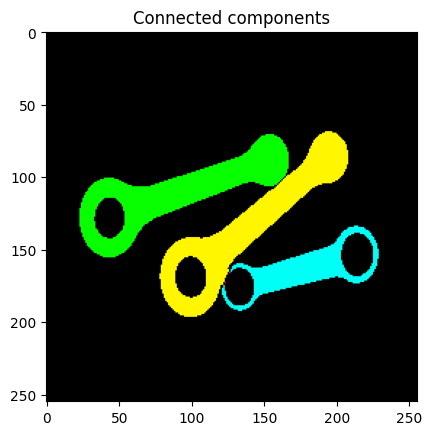

In [658]:
CONNECTIVITY = 4

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_bin, connectivity=CONNECTIVITY)

label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2RGB)
labeled_img[label_hue == 0] = 0

plt.imshow(labeled_img)
plt.title("Connected components")
plt.show()

## Detect holes & remove not rod components

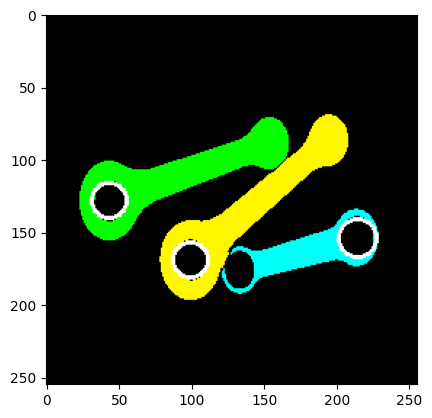

In [660]:
holes = []

for i in range(1, num_labels):
    component = np.zeros_like(labels, dtype=np.uint8)
    component[labels == i] = 255

    num_labels_c, labels_c, stats_c, centroids_c = cv2.connectedComponentsWithStats(255 - component, connectivity=CONNECTIVITY)

    c_holes = []
    for j in range(2, num_labels_c):
        diameter = math.sqrt(stats_c[j][4] / math.pi)

        hole = (centroids_c[j], diameter)
        c_holes.append(hole)

    holes.append(c_holes)

    # if the object not contains holes, it is removed from the image
    if len(c_holes) == 0:
        labels[component == 255] = 0
        labeled_img[component == 255] = 0 # just for visualization purpose
    


draw_hole_img = labeled_img.copy()
for c_hole in holes:
    for hole in c_hole:
        draw_hole_img = cv2.circle(draw_hole_img, np.rint(hole[0]).astype(int),  round(hole[1]), (255,255,255), 2)

plt.imshow(draw_hole_img)
plt.show()

## Compute moments

In [661]:
def compute_theta(moments):
    if (moments['mu20'] - moments['mu02']) == 0:
        return None
    
    theta = -0.5 * math.atan(2 * moments['mu11'] / (moments['mu20'] - moments['mu02']))

    d2theta = 2 * (moments['mu20'] - moments['mu02']) * math.cos(2 * theta) - 4 * moments['mu11'] * math.sin(2 * theta)

    if d2theta > 0:
        return theta
    else:
        return theta + math.pi / 2

def find_mer(component, angle, centroid):
    alpha = -math.sin(angle)
    beta = math.cos(angle)

    major = (alpha, -beta, beta * centroid[1] - alpha * centroid[0])
    minor = (beta, alpha, -beta * centroid[0] - alpha * centroid[1])

    c1 = c2 = c3 = c4 = (0, 0)

    max_c1_maj = max_c3_min = float("-inf")
    min_c2_maj = min_c4_min = float("inf")

    contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for p in contours[0]:
        x = p[0][0]
        y = p[0][1]

        dist_maj = (major[0] * x + major[1] * y + major[2]) / math.sqrt(major[0] ** 2 + major[1] ** 2)
        dist_min = (minor[0] * x + minor[1] * y + minor[2]) / math.sqrt(minor[0] ** 2 + minor[1] ** 2)

        # If distance from the major axis is greater than the maximum ever encountered
        if dist_maj > max_c1_maj:
            c1 = (x, y)
            max_c1_maj = dist_maj

        # If distance from the major axis is less than the minimum ever encountered
        if dist_maj < min_c2_maj:
            c2 = (x, y)
            min_c2_maj = dist_maj

        # If distance from the minor axis is greater than the maximum ever encountered
        if dist_min > max_c3_min:
            c3 = (x, y)
            max_c3_min = dist_min

        # If distance from the minor axis is less than the minimum ever encountered
        if dist_min < min_c4_min:
            c4 = (x, y)
            min_c4_min = dist_min

    # Declare a, b, a', b'
    a = alpha
    b = -beta
    a_p = beta
    b_p = alpha

    # Calculate 'c' coefficients for lines of MER's sides
    cl_1 = -(a * c1[0] + b * c1[1])
    cl_2 = -(a * c2[0] + b * c2[1])
    cw_1 = -(a_p * c3[0] + b_p * c3[1])
    cw_2 = -(a_p * c4[0] + b_p * c4[1])

    # Calculate MER vertices
    v1_x = (b * cw_1 - b_p * cl_1) / (a * b_p - b * a_p)
    v1_y = (a_p * cl_1 - a * cw_1) / (a * b_p - b * a_p)
    v1 = (v1_x, v1_y)

    v2_x = (b * cw_2 - b_p * cl_1) / (a * b_p - b * a_p)
    v2_y = (a_p * cl_1 - a * cw_2) / (a * b_p - b * a_p)
    v2 = (v2_x, v2_y)

    v3_x = (b * cw_1 - b_p * cl_2) / (a * b_p - b * a_p)
    v3_y = (a_p * cl_2 - a * cw_1) / (a * b_p - b * a_p)
    v3 = (v3_x, v3_y)

    v4_x = (b * cw_2 - b_p * cl_2) / (a * b_p - b * a_p)
    v4_y = (a_p * cl_2 - a * cw_2) / (a * b_p - b * a_p)
    v4 = (v4_x, v4_y)

    # Declare MER as the quadruple of vertices
    mer = (v1, v2, v3, v4)

    # Calculate length and width as euclidean distance
    length = dist.euclidean(v1, v2)
    width = dist.euclidean(v1, v3)

    return mer, length, width

def get_barycenter_width(component, angle, centroid):
    # Calculate alpha and beta
    alpha = -math.sin(angle)
    beta = math.cos(angle)

    # Get major and minor axis
    major = (alpha, -beta, beta * centroid[1] - alpha * centroid[0])
    minor = (beta, alpha, -beta * centroid[0] - alpha * centroid[1])

    # Points at barycenter width
    wb_1 = wb_2 = (0, 0)
    min_wb_1 = min_wb_2 = float("inf")

    # Get object contour
    contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Iterate over contour points
    for p in contours[0]:
        x = p[0][0]
        y = p[0][1]

        # Calculate signed distances between major and minor axis
        dist_maj = (major[0] * x + major[1] * y + major[2]) / math.sqrt(major[0] ** 2 + major[1] ** 2)
        dist_min = (minor[0] * x + minor[1] * y + minor[2]) / math.sqrt(minor[0] ** 2 + minor[1] ** 2)

        # If the absolute distance from the minor axis is less than the minimum ever encountered
        # for wb_1 AND the distance from the major axis is positive
        if abs(dist_min) < min_wb_1 and dist_maj > 0:
            wb_1 = (x, y)
            min_wb_1 = abs(dist_min)

        # If the absolute distance from the minor axis is less than the minimum ever encountered
        # for wb_2 AND the distance from the major axis is negative
        if abs(dist_min) < min_wb_2 and dist_maj < 0:
            wb_2 = (x, y)
            min_wb_2 = abs(dist_min)

    # Calculate width as euclidean distance
    width = dist.euclidean(wb_1, wb_2)

    # Declare the double of points at barycenter width
    wb_points = [wb_1, wb_2]

    return wb_points, width

In [662]:
def print_rod_info(centroid, mer, angle, length, width, bar_width, holes, c):
    string = ""
    rod_type = "Not a rod"

    if len(holes[c]) == 1:
        rod_type = "A"
    elif len(holes[c]) == 2:
        rod_type = "B"

    string += "Rod type:\t" + rod_type + "\n"
    string += "Position:\tCentroid = (" + "{:.2f}".format(centroid[0]) + ", " + "{:.2f}".format(
        centroid[1]) + ")\n\t\tMER = ((" + "{:.2f}".format(mer[0][0]) + ", " + "{:.2f}".format(
        mer[0][1]) + "), (" + "{:.2f}".format(mer[1][0]) + ", " + "{:.2f}".format(
        mer[1][1]) + "), (" + "{:.2f}".format(mer[2][0]) + ", " + "{:.2f}".format(mer[2][1]) + "), (" + "{:.2f}".format(
        mer[3][0]) + ", " + "{:.2f}".format(mer[3][1]) + "))\n"
    string += "Orientation:\t" + "{:.2f}".format(angle * 180 / math.pi) + " deg\n"
    string += "Size:\t\tLength = " + "{:.2f}".format(length) + "\n\t\tWidth = " + "{:.2f}".format(
        width) + "\n\t\tBarycenter width: " + "{:.2f}".format(
        bar_width) + "\n"
    string += "Holes:\t\t"

    if len(holes[c]) == 0:
        string += "None"
    else:
        for i, h in enumerate(holes[c]):
            if i > 0:
                string += "\t\t"

            string += "Hole " + str(i + 1) + ":\tCentroid = (" + \
                      "{:.2f}".format(h[0][0]) + ", " + \
                      "{:.2f}".format(h[0][1]) + ")\n\t\t\tDiameter: " + \
                      "{:.2f}".format(h[1]) + "\n"

    print(string)

In [663]:
visualization = True

for i in range(1, num_labels):
    component = get_component(labels, i)

    num_labels_c, labels_c, stats_c, centroids_c = cv2.connectedComponentsWithStats(255 - component, connectivity=CONNECTIVITY)

    # get baricenter points and width
    moments = cv2.moments(component, binaryImage = True)
    theta = compute_theta(moments)
    bar_points, bar_width = get_barycenter_width(component, theta, centroids[i])

    # finde MER
    mer, length, width = find_mer(component, theta, centroids[i])

    enlongatedness = length / width

    # if the object ins't a rod, it's ignored and removed from image (just for visualization purpose)
    if len(holes[i-1]) == 0 or enlongatedness < 1.8:
        labeled_img[component == 255] = 0 # just for visualization purpose
        continue
    
    # iteration over holes
    for j in range(2, num_labels_c):
        component_c = get_component(labels_c, j)

        moments_c = cv2.moments(component_c, True)
        theta_c = compute_theta(moments_c)

        # draw centroids
        cv2.circle(labeled_img, (int(centroids_c[j][0]), int(centroids_c[j][1])), 2, (255, 255, 255), -1) 

    
    print_rod_info(centroids[i], mer, theta, length, width, bar_width, holes, i-1)

    # ----- VISUALIZATION -----
    if visualization:
        # draw centroids
        cv2.circle(labeled_img, (int(centroids[j][0]), int(centroids[j][1])), 2, (255, 255, 255), -1)

        # draw mer
        v1, v2, v3, v4 = mer[0], mer[1], mer[2], mer[3]
        cv2.line(labeled_img, (int(v1[0]), int(v1[1])), (int(v3[0]), int(v3[1])), (255, 255, 255), 1, cv2.LINE_AA)
        cv2.line(labeled_img, (int(v2[0]), int(v2[1])), (int(v1[0]), int(v1[1])), (255, 255, 255), 1, cv2.LINE_AA)
        cv2.line(labeled_img, (int(v3[0]), int(v3[1])), (int(v4[0]), int(v4[1])), (255, 255, 255), 1, cv2.LINE_AA)
        cv2.line(labeled_img, (int(v4[0]), int(v4[1])), (int(v2[0]), int(v2[1])), (255, 255, 255), 1, cv2.LINE_AA)

        # draw orentation axis
        # length = int(length * 1.3 / 2)
        length = int(length)
        alpha = -math.sin(theta)
        beta = math.cos(theta)

        p1 = (int(centroids[i][0] + length * beta),
            int(centroids[i][1] + length * alpha))

        p2 = (int(centroids[i][0] - length * beta),
            int(centroids[i][1] - length * alpha))

        cv2.line(labeled_img, (p1[0], p1[1]), (p2[0], p2[1]), (255, 255, 255), 1, cv2.LINE_AA)

        # draw baricentre width
        p1, p2 = bar_points[0], bar_points[1]

        cv2.line(labeled_img, (p1[0], p1[1]), (p2[0], p2[1]), (255, 255, 255), 1, cv2.LINE_AA)

plt.imshow(labeled_img)
plt.show()

Rod type:	A
Position:	Centroid = (139.82, 133.70)
		MER = ((188.13, 57.00), (64.86, 166.44), (220.83, 93.83), (97.56, 203.27))
Orientation:	41.60 deg
Size:		Length = 164.84
		Width = 49.26
		Barycenter width: 19.10
Holes:		Hole 1:	Centroid = (99.12, 169.02)
			Diameter: 12.32

Rod type:	A
Position:	Centroid = (90.68, 110.88)
		MER = ((156.90, 57.96), (13.80, 110.52), (175.25, 107.90), (32.15, 160.46))
Orientation:	20.17 deg
Size:		Length = 152.45
		Width = 53.20
		Barycenter width: 20.25
Holes:		Hole 1:	Centroid = (43.32, 128.30)
			Diameter: 12.07

Rod type:	A
Position:	Centroid = (178.08, 163.51)
		MER = ((222.24, 130.60), (115.61, 163.55), (233.57, 167.26), (126.94, 200.21))
Orientation:	17.17 deg
Size:		Length = 111.61
		Width = 38.37
		Barycenter width: 19.92
Holes:		Hole 1:	Centroid = (213.67, 153.56)
			Diameter: 12.85



TypeError: must be real number, not NoneType